#Survival classification using Titanic dataset

This notebook adress the problem of predicting if the passangers of the Titanic would survive or not, using some simple information about demography, tickets and location.
In this case, the whole process to address a Data Science process is done. Starting by the cleaning of the data, the exploratory data análisis, feature engineering and implementation and tuning of models.

#Loading Libraries

In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

#Loading data

This problem was taken from a Kaggle competition, so we have a test data that is not labeled. This is the prediction that must be made to participate in the competition.
We start by concatenating the 2 datasets to make the data cleaning the same for both, however we are going to split them later.

In [249]:
training_data= pd.read_csv('train.csv')
test_data= pd.read_csv('test.csv')
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The columns availables are:
- PassengerId: the unique id of the row and it doesn't have any effect on target
- Survived: the target variable we are trying to predict (0 or 1):
1 = Survived, 0 = Not Survived
- Pclass (Passenger Class): is the socio-economic status of the passenger and it is a categorical ordinal feature which has 3 unique values (1, 2 or 3):
1 = Upper Class, 2 = Middle Class, 3 = Lower Class
- Name, Sex and Age are self-explanatory
- SibSp: the total number of the passengers' siblings and spouse
- Parch: the total number of the passengers' parents and children
- Ticket: the ticket number of the passenger
- Fare: the passenger fare
- Cabin: the cabin number of the passenger


In [250]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

train_data = concat_df(training_data, test_data)

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Fare'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Survived'}>, <Axes: >, <Axes: >]],
      dtype=object)

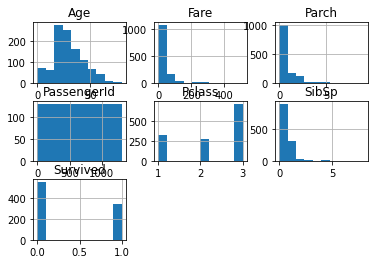

In [251]:
train_data.hist()

We can see that the age has a distributin similar to a normal distribution, however the fare is skewed, and this could have some impacts in the results.

<Axes: >

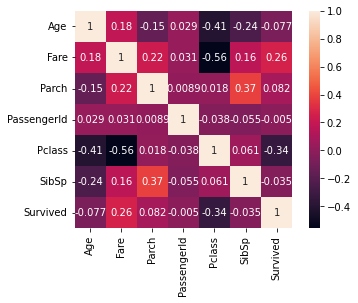

In [252]:
sns.heatmap(train_data.corr(), square=True,annot=True)

On the correlation matrix we can see that there are some important relationships, like Pclass with Fare with a correlation of -0.56 or Pclass with age with -0.41. This correlations make sense, as they implied that people of Upper class payed a higher fare and that people from Upper class tend to have more age.

#Data cleaning and feature engineering

In [253]:
print('Null Values =',train_data.isnull().sum())

Null Values = Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64


We first look at the missing values, we can see that there are a lot of missing values in cabin and age. The column cabin will not say much, but we can extract some other variables from it

In [254]:
train_data['Cabin'][:30]

0             NaN
1             C85
2             NaN
3            C123
4             NaN
5             NaN
6             E46
7             NaN
8             NaN
9             NaN
10             G6
11           C103
12            NaN
13            NaN
14            NaN
15            NaN
16            NaN
17            NaN
18            NaN
19            NaN
20            NaN
21            D56
22            NaN
23             A6
24            NaN
25            NaN
26            NaN
27    C23 C25 C27
28            NaN
29            NaN
Name: Cabin, dtype: object

 From the cabin data we extract the first letter, as it indicates the sector of the ship where their cabin was located, and could be a significant variable.

In [255]:
train_data['Cabin_l']= train_data.Cabin.apply(lambda x: str(x)[0])
idx = train_data[train_data['Cabin_l'] == 'T'].index
train_data.loc[idx, 'Deck'] = 'A'


In [256]:
print(pd.pivot_table(train_data, index='Survived', columns='Pclass', values='Ticket', aggfunc='count'))

Pclass      1   2    3
Survived              
0.0        80  97  372
1.0       136  87  119


On the column Cabin we can see that some passangers had more than one cabin, so we are going count them and use it as another variable that could help in the prediction

In [257]:
train_data['Cabin_multiple']= train_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))

Now from the name we can extract also the title of each person and save it in another column

In [258]:
train_data['title']= train_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

Looking at the tickets, there are a lot of different formats, so we are going to create a binary variable that states if is numeric or not and also a variable with all the letters cleaned

In [259]:
train_data['Ticket']

0                A/5 21171
1                 PC 17599
2         STON/O2. 3101282
3                   113803
4                   373450
               ...        
1304             A.5. 3236
1305              PC 17758
1306    SOTON/O.Q. 3101262
1307                359309
1308                  2668
Name: Ticket, Length: 1309, dtype: object

In [260]:
train_data['numeric_ticket']= train_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0 )
train_data['ticket_letters']= train_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.', '').replace('/','').lower() if len(x.split(' ')[:-1])>0 else 0)

In [261]:
train_data['title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: title, dtype: int64

For the missing values of age we use the median age of passengers with the same Sex and Pclass, because as we stated before, there is a high correlation between them, so it should be a good aproximator 

In [262]:
age_by_pclass_sex = train_data.groupby(['Sex', 'Pclass']).median()['Age']
train_data['Age']= train_data.groupby(['Sex','Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [263]:
train_data['Embarked']= train_data['Embarked'].fillna(value='S', inplace=True)

med_fare= train_data.groupby(['Pclass','Parch','SibSp']).Fare.median()[3][0][0]
train_data['Fare'].fillna(value=med_fare, inplace=True)


Creation of other variables that might be helpful for the model

In [264]:
train_data['Family_Size'] = train_data['SibSp'] + train_data['Parch'] + 1
train_data['Ticket_Frequency'] = train_data.groupby('Ticket')['Ticket'].transform('count')

Normalization of the Fare

In [265]:
train_data['norm_Fare']= np.log(train_data['Fare']+1)

Now we choose the variables that are going to be used in the models and divide the data into train and test sets

In [266]:

features = ["Survived","Pclass", "Sex", "SibSp", "Parch", "Age", "Fare", 'Embarked',"Cabin_l", "Cabin_multiple", 'title', 'numeric_ticket','ticket_letters', 'Family_Size','Ticket_Frequency']
X = pd.get_dummies(train_data[features])

X.columns = [col.replace('[', '(').replace(']',')') for col in X.columns.tolist()]


X, test_x = divide_df(X)

y = X["Survived"]
X=X.drop(columns=['Survived'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [267]:
#scaler= StandardScaler()
#X_train=scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)
#test_x= scaler.transform(test_x)


#Machine Learning Models

Now that the data is ready, it is time to train and test the models.
Several models were used looking for the best predictor.
In each model cross validation was used to avoid overfitting.
Also they are tested with confusion matrix and a classification report that have all the metrics of the test set

In [268]:
kf=KFold(n_splits=5, shuffle=True, random_state=42)
#SVR
SVC_rbf=SVC(kernel='rbf',C=1,gamma=0.1)
cv_results_SVC= cross_val_score(SVC_rbf, X_train, y_train, cv=kf)
print('Cross-Validation',cv_results_SVC, 'Mean',np.mean(cv_results_SVC), 'Std',np.std(cv_results_SVC))
SVC_rbf.fit(X_train, y_train)
y_pred= SVC_rbf.predict(X_test)
print('Confusion Matrix:','\n',confusion_matrix(y_test, y_pred))
print('Classification_report: ','\n', classification_report(y_test, y_pred))


Cross-Validation [0.70186335 0.76875    0.81875    0.775      0.69375   ] Mean 0.7516226708074535 Std 0.047267660999450116
Confusion Matrix: 
 [[44  7]
 [19 20]]
Classification_report:  
               precision    recall  f1-score   support

         0.0       0.70      0.86      0.77        51
         1.0       0.74      0.51      0.61        39

    accuracy                           0.71        90
   macro avg       0.72      0.69      0.69        90
weighted avg       0.72      0.71      0.70        90



###Decision Tree

In [269]:
kf=KFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {}
#TREE
clf1 = DecisionTreeClassifier(criterion='entropy', min_samples_split=2, min_samples_leaf=1)
cv_results_SVC= cross_val_score(clf1, X_train, y_train, cv=kf)
print('Cross-Validation',cv_results_SVC, 'Mean',np.mean(cv_results_SVC), 'Std',np.std(cv_results_SVC))
clf1.fit(X_train, y_train)
y_pred= clf1.predict(X_test)
print('Confusion Matrix:','\n',confusion_matrix(y_test, y_pred))
print('Classification_report: ','\n', classification_report(y_test, y_pred))

Cross-Validation [0.74534161 0.7625     0.825      0.78125    0.79375   ] Mean 0.7815683229813665 Std 0.027242541997386727
Confusion Matrix: 
 [[43  8]
 [14 25]]
Classification_report:  
               precision    recall  f1-score   support

         0.0       0.75      0.84      0.80        51
         1.0       0.76      0.64      0.69        39

    accuracy                           0.76        90
   macro avg       0.76      0.74      0.75        90
weighted avg       0.76      0.76      0.75        90



###Logistic

In [270]:
kf=KFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {}
#TREE
regL = LogisticRegression()
cv_results_SVC= cross_val_score(regL, X_train, y_train, cv=kf)
print('Cross-Validation',cv_results_SVC, 'Mean',np.mean(cv_results_SVC), 'Std',np.std(cv_results_SVC))
regL.fit(X_train, y_train)
y_pred= regL.predict(X_test)
print('Confusion Matrix:','\n',confusion_matrix(y_test, y_pred))
print('Classification_report: ','\n', classification_report(y_test, y_pred))

Cross-Validation [0.79503106 0.7875     0.8875     0.81875    0.80625   ] Mean 0.8190062111801242 Std 0.03583750853043597
Confusion Matrix: 
 [[45  6]
 [ 9 30]]
Classification_report:  
               precision    recall  f1-score   support

         0.0       0.83      0.88      0.86        51
         1.0       0.83      0.77      0.80        39

    accuracy                           0.83        90
   macro avg       0.83      0.83      0.83        90
weighted avg       0.83      0.83      0.83        90



###Random Forest

For the Random Forest we choose to use a grid search to look for the best parameters and achieve a better accuracy

In [282]:
kf=KFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {'criterion':['gini','entropy','log_loss'], 'max_depth':[None,10,50], 'min_samples_split':[2,4,8], 'n_estimators':[10,50,100]}
clf=RandomForestClassifier()
clf_cv=GridSearchCV(clf, param_grid, cv=kf)
clf_cv.fit(X_train, y_train)
print(clf_cv.best_params_, clf_cv.best_score_)

{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 4, 'n_estimators': 100} 0.8402329192546583


Then these parameters are used to train the model

In [283]:
kf=KFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {}
#TREE
clf=RandomForestClassifier(n_estimators= 100, criterion='gini', max_depth=None, min_samples_split=4)
cv_results_SVC= cross_val_score(clf, X_train, y_train, cv=kf)
print('Cross-Validation',cv_results_SVC, 'Mean',np.mean(cv_results_SVC), 'Std',np.std(cv_results_SVC))
clf.fit(X_train, y_train)
y_pred= clf.predict(X_test)
print('Confusion Matrix:','\n',confusion_matrix(y_test, y_pred))
print('Classification_report: ','\n', classification_report(y_test, y_pred))

Cross-Validation [0.80745342 0.81875    0.8625     0.83125    0.8375    ] Mean 0.8314906832298137 Std 0.018643297781716944
Confusion Matrix: 
 [[49  2]
 [12 27]]
Classification_report:  
               precision    recall  f1-score   support

         0.0       0.80      0.96      0.88        51
         1.0       0.93      0.69      0.79        39

    accuracy                           0.84        90
   macro avg       0.87      0.83      0.83        90
weighted avg       0.86      0.84      0.84        90



###KNN

In [275]:
kf=KFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {}
knn=KNeighborsClassifier()
cv_results_SVC= cross_val_score(knn, X_train, y_train, cv=kf)
print('Cross-Validation',cv_results_SVC, 'Mean',np.mean(cv_results_SVC), 'Std',np.std(cv_results_SVC))
knn.fit(X_train, y_train)
y_pred= knn.predict(X_test)
print('Confusion Matrix:','\n',confusion_matrix(y_test, y_pred))
print('Classification_report: ','\n', classification_report(y_test, y_pred))

Cross-Validation [0.71428571 0.73125    0.8125     0.73125    0.73125   ] Mean 0.7441071428571429 Std 0.034821886443876134
Confusion Matrix: 
 [[44  7]
 [15 24]]
Classification_report:  
               precision    recall  f1-score   support

         0.0       0.75      0.86      0.80        51
         1.0       0.77      0.62      0.69        39

    accuracy                           0.76        90
   macro avg       0.76      0.74      0.74        90
weighted avg       0.76      0.76      0.75        90



###AdaBoost

Now some ensembled models

In [274]:
kf=KFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {}
#TREE
abc=AdaBoostClassifier(base_estimator= regL,n_estimators=100)
cv_results_SVC= cross_val_score(abc, X_train, y_train, cv=kf)
print('Cross-Validation',cv_results_SVC, 'Mean',np.mean(cv_results_SVC), 'Std',np.std(cv_results_SVC))
abc.fit(X_train, y_train)
y_pred= abc.predict(X_test)
print('Confusion Matrix:','\n',confusion_matrix(y_test, y_pred))
print('Classification_report: ','\n', classification_report(y_test, y_pred))

Cross-Validation [0.79503106 0.8125     0.88125    0.81875    0.79375   ] Mean 0.8202562111801243 Std 0.03200486665678771
Confusion Matrix: 
 [[45  6]
 [ 9 30]]
Classification_report:  
               precision    recall  f1-score   support

         0.0       0.83      0.88      0.86        51
         1.0       0.83      0.77      0.80        39

    accuracy                           0.83        90
   macro avg       0.83      0.83      0.83        90
weighted avg       0.83      0.83      0.83        90



###Gradient Booster

In [277]:
kf=KFold(n_splits=6, shuffle=True, random_state=42)
param_grid = {}
gbc = GradientBoostingClassifier(init=regL, learning_rate=0.1, n_estimators=100)
cv_results_SVC= cross_val_score(regL, X_train, y_train, cv=kf)
print('Cross-Validation',cv_results_SVC, 'Mean',np.mean(cv_results_SVC), 'Std',np.std(cv_results_SVC))
gbc.fit(X_train, y_train)
y_pred= gbc.predict(X_test)
print('Confusion Matrix:','\n',confusion_matrix(y_test, y_pred))
print('Classification_report: ','\n', classification_report(y_test, y_pred))

Cross-Validation [0.78358209 0.7761194  0.86567164 0.88721805 0.84962406 0.78195489] Mean 0.8240283544682603 Std 0.04487684101422092
Confusion Matrix: 
 [[47  4]
 [ 8 31]]
Classification_report:  
               precision    recall  f1-score   support

         0.0       0.85      0.92      0.89        51
         1.0       0.89      0.79      0.84        39

    accuracy                           0.87        90
   macro avg       0.87      0.86      0.86        90
weighted avg       0.87      0.87      0.87        90



In [278]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
cv_results_SVC= cross_val_score(xgb_model, X_train, y_train, cv=kf)
print('Cross-Validation',cv_results_SVC, 'Mean',np.mean(cv_results_SVC), 'Std',np.std(cv_results_SVC))

Cross-Validation [0.7761194  0.82835821 0.82835821 0.86466165 0.80451128 0.78947368] Mean 0.815247072906146 Std 0.02914362143313836


Finally, we got great results from some of the models, but a good way to hedge the overfitting and to have a more general prediction is to combine them. So a final Voting Classifier is made using the models with the best scores.
This voting model achieved the best score and is a good predictor of the survival label of the titanic dataset

In [279]:
from sklearn.ensemble import VotingClassifier
voting_clf= VotingClassifier(estimators=[('clf',clf),('gbc',gbc),('xgb',xgb_model), ('abc', abc)], voting='soft')
cv_results_SVC= cross_val_score(voting_clf, X_train, y_train, cv=kf)
print('Cross-Validation',cv_results_SVC, 'Mean',np.mean(cv_results_SVC), 'Std',np.std(cv_results_SVC))
voting_clf.fit(X_train, y_train)
y_pred= voting_clf.predict(X_test)
print('Confusion Matrix:','\n',confusion_matrix(y_test, y_pred))
print('Classification_report: ','\n', classification_report(y_test, y_pred))

Cross-Validation [0.82835821 0.79850746 0.84328358 0.87969925 0.84962406 0.80451128] Mean 0.8339973066995848 Std 0.02762804164864576
Confusion Matrix: 
 [[49  2]
 [10 29]]
Classification_report:  
               precision    recall  f1-score   support

         0.0       0.83      0.96      0.89        51
         1.0       0.94      0.74      0.83        39

    accuracy                           0.87        90
   macro avg       0.88      0.85      0.86        90
weighted avg       0.88      0.87      0.86        90



In [280]:
predictions= voting_clf.predict(test_x)

In [281]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission_new.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
